In [ ]:
!pip install gensim --upgrade
!pip install keras --upgrade
!pip install pandas --upgrade

     |████████████████████████████████| 24.2MB 135kB/s 
  Found existing installation: gensim 3.6.0
    Uninstalling gensim-3.6.0:
      Successfully uninstalled gensim-3.6.0
Requirement already up-to-date: keras in /usr/local/lib/python3.6/dist-packages (2.4.3)
Requirement already up-to-date: pandas in /usr/local/lib/python3.6/dist-packages (1.1.5)


In [ ]:
# DataFrame
import pandas as pd

# Matplot
import matplotlib.pyplot as plt

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer

# Keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, Embedding, Flatten, Conv1D, MaxPooling1D, LSTM
from keras import utils
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

# nltk
import nltk
from nltk.corpus import stopwords
from  nltk.stem import SnowballStemmer

# Word2vec
import gensim

# Utility
import re
import numpy as np
import os
from collections import Counter
import logging
import time
import pickle
import itertools

# Set log
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [ ]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
# DATASET
DATASET_COLUMNS = ["target", "ids", "date", "flag", "user", "text"]
DATASET_ENCODING = "ISO-8859-1"
TRAIN_SIZE = 0.8

# TEXT CLENAING
TEXT_CLEANING_RE = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

# WORD2VEC 
W2V_SIZE = 300
W2V_WINDOW = 7
W2V_EPOCH = 32
W2V_MIN_COUNT = 10

# KERAS
SEQUENCE_LENGTH = 300
EPOCHS = 8
BATCH_SIZE = 1024

# SENTIMENT
POSITIVE = "POSITIVE"
NEGATIVE = "NEGATIVE"
NEUTRAL = "NEUTRAL"
SENTIMENT_THRESHOLDS = (0.4, 0.7)

# EXPORT
KERAS_MODEL = "model.h5"
WORD2VEC_MODEL = "model.w2v"
TOKENIZER_MODEL = "tokenizer.pkl"
ENCODER_MODEL = "encoder.pkl"

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
dataset_filename = '/content/drive/MyDrive/Project SA/training.1600000.processed.noemoticon.csv'
dataset_path = dataset_filename
print("Open file:", dataset_path)
df = pd.read_csv(dataset_path, encoding =DATASET_ENCODING , names=DATASET_COLUMNS)

Open file: /content/drive/MyDrive/Project SA/training.1600000.processed.noemoticon.csv


In [ ]:
print("Dataset size:", len(df))


Dataset size: 1600000


In [ ]:
df.head(5)

,target,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [ ]:
decode_map = {0: "NEGATIVE", 2: "NEUTRAL", 4: "POSITIVE"}
def decode_sentiment(label):
    return decode_map[int(label)]

In [ ]:
df.target = df.target.apply(lambda x: decode_sentiment(x))

Text(0.5, 1.0, 'Dataset labels distribuition')

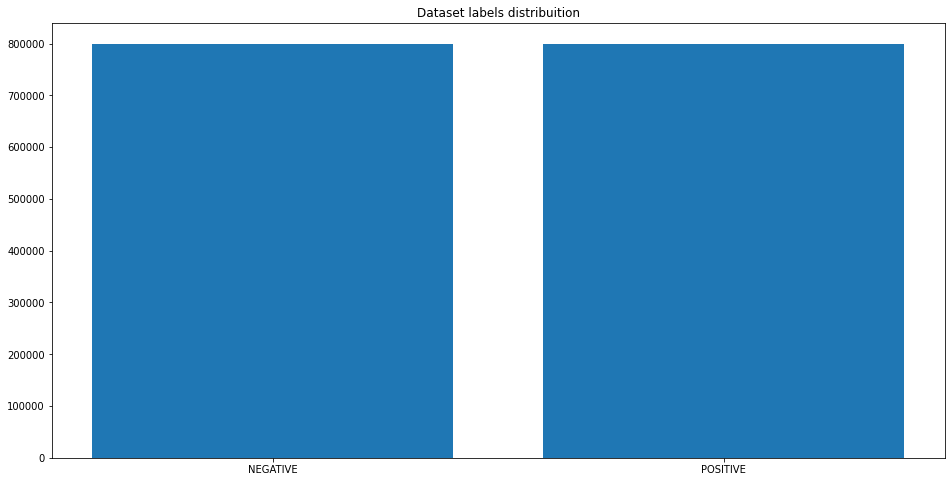

In [ ]:
target_cnt = Counter(df.target)

plt.figure(figsize=(16,8))
plt.bar(target_cnt.keys(), target_cnt.values())
plt.title("Dataset labels distribuition")

In [ ]:
stop_words = stopwords.words("english")
stemmer = SnowballStemmer("english")

In [ ]:
def preprocess(text, stem=False):
    # Remove link,user and special characters
    text = re.sub(TEXT_CLEANING_RE, ' ', str(text).lower()).strip()
    tokens = []
    for token in text.split():
        if token not in stop_words:
            if stem:
                tokens.append(stemmer.stem(token))
            else:
                tokens.append(token)
    return " ".join(tokens)

In [ ]:
df.text = df.text.apply(lambda x: preprocess(x))

In [ ]:
df.head(5)

,target,ids,date,flag,user,text
0,NEGATIVE,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,awww bummer shoulda got david carr third day
1,NEGATIVE,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,upset update facebook texting might cry result...
2,NEGATIVE,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,dived many times ball managed save 50 rest go ...
3,NEGATIVE,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,whole body feels itchy like fire
4,NEGATIVE,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,behaving mad see


In [ ]:
df_train, df_test = train_test_split(df, test_size=1-TRAIN_SIZE, random_state=42)
print("TRAIN size:", len(df_train))
print("TEST size:", len(df_test))

TRAIN size: 1280000
TEST size: 320000


In [ ]:
documents = [_text.split() for _text in df_train.text] 

In [ ]:
len(documents)

1280000

In [ ]:
w2v_model = gensim.models.word2vec.Word2Vec(size=W2V_SIZE, 
                                            window=W2V_WINDOW, 
                                            min_count=W2V_MIN_COUNT, 
                                            workers=8)

In [ ]:
w2v_model.build_vocab(documents)

2021-01-09 08:05:24,009 : INFO : collecting all words and their counts
2021-01-09 08:05:24,010 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2021-01-09 08:05:24,046 : INFO : PROGRESS: at sentence #10000, processed 72565 words, keeping 14005 word types
2021-01-09 08:05:24,065 : INFO : PROGRESS: at sentence #20000, processed 144393 words, keeping 21587 word types
2021-01-09 08:05:24,088 : INFO : PROGRESS: at sentence #30000, processed 215826 words, keeping 27541 word types
2021-01-09 08:05:24,111 : INFO : PROGRESS: at sentence #40000, processed 288271 words, keeping 32764 word types
2021-01-09 08:05:24,135 : INFO : PROGRESS: at sentence #50000, processed 359772 words, keeping 37587 word types
2021-01-09 08:05:24,162 : INFO : PROGRESS: at sentence #60000, processed 431431 words, keeping 42198 word types
2021-01-09 08:05:24,183 : INFO : PROGRESS: at sentence #70000, processed 503103 words, keeping 46458 word types
2021-01-09 08:05:24,210 : INFO : PROGRESS: at s

In [ ]:
words = w2v_model.wv.vocab.keys()
vocab_size = len(words)
print("Vocab size", vocab_size)

Vocab size 30369


In [ ]:
%%time
w2v_model.train(documents, total_examples=len(documents), epochs=W2V_EPOCH)

2021-01-09 08:05:38,676 : INFO : training model with 8 workers on 30369 vocabulary and 300 features, using sg=0 hs=0 sample=0.001 negative=5 window=7
2021-01-09 08:05:39,730 : INFO : EPOCH 1 - PROGRESS: at 4.13% examples, 337221 words/s, in_qsize 15, out_qsize 6
2021-01-09 08:05:40,731 : INFO : EPOCH 1 - PROGRESS: at 9.23% examples, 374038 words/s, in_qsize 15, out_qsize 2
2021-01-09 08:05:41,777 : INFO : EPOCH 1 - PROGRESS: at 14.33% examples, 382471 words/s, in_qsize 15, out_qsize 0
2021-01-09 08:05:42,833 : INFO : EPOCH 1 - PROGRESS: at 19.62% examples, 390243 words/s, in_qsize 16, out_qsize 0
2021-01-09 08:05:43,884 : INFO : EPOCH 1 - PROGRESS: at 24.72% examples, 391931 words/s, in_qsize 14, out_qsize 1
2021-01-09 08:05:44,938 : INFO : EPOCH 1 - PROGRESS: at 29.91% examples, 394242 words/s, in_qsize 15, out_qsize 0
2021-01-09 08:05:46,040 : INFO : EPOCH 1 - PROGRESS: at 34.78% examples, 389708 words/s, in_qsize 13, out_qsize 6
2021-01-09 08:05:47,052 : INFO : EPOCH 1 - PROGRESS: a

CPU times: user 20min 34s, sys: 5.14 s, total: 20min 39s
Wall time: 10min 38s


(263126324, 295270528)

In [ ]:
w2v_model.most_similar("hate")


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.
2021-01-09 08:17:15,707 : INFO : precomputing L2-norms of word weight vectors


[('hates', 0.5516266822814941),
 ('sucks', 0.5049316883087158),
 ('dislike', 0.4951819181442261),
 ('stupid', 0.47495031356811523),
 ('suck', 0.45793038606643677),
 ('despise', 0.44821807742118835),
 ('ugh', 0.43089908361434937),
 ('hating', 0.43033385276794434),
 ('h8', 0.4284934401512146),
 ('annoying', 0.3965412974357605)]

In [ ]:
%%time
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_train.text)

vocab_size = len(tokenizer.word_index) + 1
print("Total words", vocab_size)

Total words 290419
CPU times: user 15 s, sys: 74 ms, total: 15.1 s
Wall time: 15.1 s


In [ ]:
%%time
x_train = pad_sequences(tokenizer.texts_to_sequences(df_train.text), maxlen=SEQUENCE_LENGTH)
x_test = pad_sequences(tokenizer.texts_to_sequences(df_test.text), maxlen=SEQUENCE_LENGTH)

CPU times: user 22.5 s, sys: 473 ms, total: 23 s
Wall time: 23 s


In [ ]:
labels = df_train.target.unique().tolist()
labels.append(NEUTRAL)
labels

['POSITIVE', 'NEGATIVE', 'NEUTRAL']

In [ ]:
encoder = LabelEncoder()
encoder.fit(df_train.target.tolist())

y_train = encoder.transform(df_train.target.tolist())
y_test = encoder.transform(df_test.target.tolist())

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

print("y_train",y_train.shape)
print("y_test",y_test.shape)

y_train (1280000, 1)
y_test (320000, 1)


In [ ]:
print("x_train", x_train.shape)
print("y_train", y_train.shape)
print()
print("x_test", x_test.shape)
print("y_test", y_test.shape)

x_train (1280000, 300)
y_train (1280000, 1)

x_test (320000, 300)
y_test (320000, 1)


In [ ]:
y_train[:10]

array([[1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1]])

In [ ]:
embedding_matrix = np.zeros((vocab_size, W2V_SIZE))
for word, i in tokenizer.word_index.items():
  if word in w2v_model.wv:
    embedding_matrix[i] = w2v_model.wv[word]
print(embedding_matrix.shape)

(290419, 300)


In [ ]:
embedding_layer = Embedding(vocab_size, W2V_SIZE, weights=[embedding_matrix], input_length=SEQUENCE_LENGTH, trainable=False)

In [ ]:
model = Sequential()
model.add(embedding_layer)
model.add(Dropout(0.5))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

model.summary()

2021-01-09 08:18:47,514 : WARNING : Layer lstm will not use cuDNN kernel since it doesn't meet the cuDNN kernel criteria. It will use generic GPU kernel as fallback when running on GPU


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 300, 300)          87125700  
_________________________________________________________________
dropout (Dropout)            (None, 300, 300)          0         
_________________________________________________________________
lstm (LSTM)                  (None, 100)               160400    
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 87,286,201
Trainable params: 160,501
Non-trainable params: 87,125,700
_________________________________________________________________


In [ ]:
model.compile(loss='binary_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])

In [ ]:
callbacks = [ ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
              EarlyStopping(monitor='val_acc', min_delta=1e-4, patience=5)]

In [ ]:
%%time
history = model.fit(x_train, y_train,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_split=0.1,
                    verbose=1,
                    callbacks=callbacks)

Epoch 1/8
1125/1125 [==============================] - 658s 581ms/step - loss: 0.5285 - accuracy: 0.7315 - val_loss: 0.4649 - val_accuracy: 0.7797


2021-01-09 08:29:58,825 : WARNING : Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


Epoch 2/8
1125/1125 [==============================] - 656s 583ms/step - loss: 0.4812 - accuracy: 0.7656 - val_loss: 0.4597 - val_accuracy: 0.7831


2021-01-09 08:40:54,532 : WARNING : Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


Epoch 3/8
1125/1125 [==============================] - 645s 573ms/step - loss: 0.4718 - accuracy: 0.7722 - val_loss: 0.4574 - val_accuracy: 0.7852


2021-01-09 08:51:39,696 : WARNING : Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


Epoch 4/8
1125/1125 [==============================] - 649s 577ms/step - loss: 0.4685 - accuracy: 0.7742 - val_loss: 0.4528 - val_accuracy: 0.7881


2021-01-09 09:02:29,115 : WARNING : Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


Epoch 5/8
1125/1125 [==============================] - 653s 581ms/step - loss: 0.4652 - accuracy: 0.7759 - val_loss: 0.4520 - val_accuracy: 0.7884


2021-01-09 09:13:22,381 : WARNING : Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


Epoch 6/8
1125/1125 [==============================] - 651s 579ms/step - loss: 0.4628 - accuracy: 0.7770 - val_loss: 0.4485 - val_accuracy: 0.7897


2021-01-09 09:24:13,811 : WARNING : Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


Epoch 7/8
1125/1125 [==============================] - 650s 578ms/step - loss: 0.4625 - accuracy: 0.7778 - val_loss: 0.4485 - val_accuracy: 0.7906


2021-01-09 09:35:03,652 : WARNING : Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


Epoch 8/8
1125/1125 [==============================] - 649s 577ms/step - loss: 0.4607 - accuracy: 0.7793 - val_loss: 0.4470 - val_accuracy: 0.7914


2021-01-09 09:45:53,092 : WARNING : Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


CPU times: user 1h 36min 54s, sys: 3min 36s, total: 1h 40min 31s
Wall time: 1h 26min 52s


In [ ]:
%%time
score = model.evaluate(x_test, y_test, batch_size=BATCH_SIZE)
print()
print("ACCURACY:",score[1])
print("LOSS:",score[0])

313/313 [==============================] - 57s 180ms/step - loss: 0.4455 - accuracy: 0.7917

ACCURACY: 0.7917218804359436
LOSS: 0.445529043674469
CPU times: user 53.5 s, sys: 2.2 s, total: 55.7 s
Wall time: 56.8 s


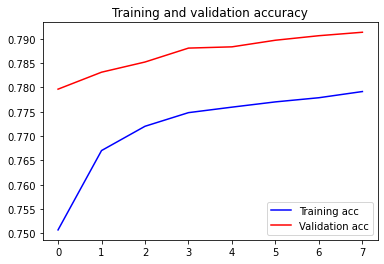

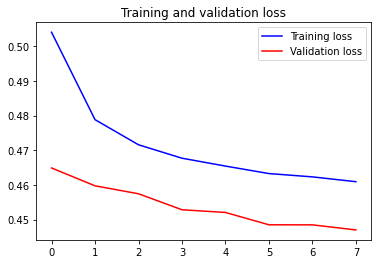

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

In [ ]:
def decode_sentiment(score, include_neutral=True):
    if include_neutral:        
        label = NEUTRAL
        if score <= SENTIMENT_THRESHOLDS[0]:
            label = NEGATIVE
        elif score >= SENTIMENT_THRESHOLDS[1]:
            label = POSITIVE

        return label
    else:
        return NEGATIVE if score < 0.5 else POSITIVE

In [ ]:
def predict(text, include_neutral=True):
    start_at = time.time()
    # Tokenize text
    x_test = pad_sequences(tokenizer.texts_to_sequences([text]), maxlen=SEQUENCE_LENGTH)
    # Predict
    score = model.predict([x_test])[0]
    # Decode sentiment
    label = decode_sentiment(score, include_neutral=include_neutral)

    return {"label": label, "score": float(score),
       "elapsed_time": time.time()-start_at} 

In [ ]:
predict("I love the music")

{'elapsed_time': 0.38802528381347656,
 'label': 'POSITIVE',
 'score': 0.9708119034767151}

In [ ]:
predict("I hate the rain")

{'elapsed_time': 0.11771297454833984,
 'label': 'NEGATIVE',
 'score': 0.0074637760408222675}

In [ ]:
predict("i don't know what i'm doing")

{'elapsed_time': 0.11155986785888672,
 'label': 'NEGATIVE',
 'score': 0.28013870120048523}

In [ ]:
%%time
y_pred_1d = []
y_test_1d = list(df_test.target)
scores = model.predict(x_test, verbose=1, batch_size=8000)
y_pred_1d = [decode_sentiment(score, include_neutral=False) for score in scores]

40/40 [==============================] - 44s 1s/step
CPU times: user 35.1 s, sys: 11.5 s, total: 46.6 s
Wall time: 44.8 s


In [ ]:
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=30)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90, fontsize=22)
    plt.yticks(tick_marks, classes, fontsize=22)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=25)
    plt.xlabel('Predicted label', fontsize=25)

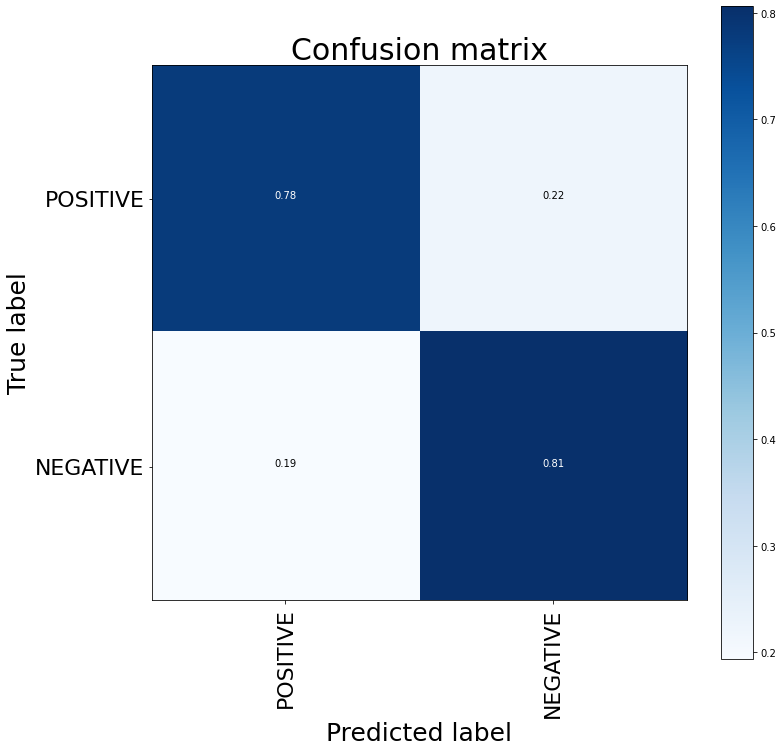

CPU times: user 1.11 s, sys: 21.7 ms, total: 1.14 s
Wall time: 1.15 s


In [ ]:
%%time

cnf_matrix = confusion_matrix(y_test_1d, y_pred_1d)
plt.figure(figsize=(12,12))
plot_confusion_matrix(cnf_matrix, classes=df_train.target.unique(), title="Confusion matrix")
plt.show()

In [ ]:
print(classification_report(y_test_1d, y_pred_1d))


              precision    recall  f1-score   support

    NEGATIVE       0.80      0.78      0.79    159494
    POSITIVE       0.78      0.81      0.80    160506

    accuracy                           0.79    320000
   macro avg       0.79      0.79      0.79    320000
weighted avg       0.79      0.79      0.79    320000



In [ ]:
accuracy_score(y_test_1d, y_pred_1d)


0.791721875

In [ ]:
model.save(KERAS_MODEL)
w2v_model.save(WORD2VEC_MODEL)
pickle.dump(tokenizer, open(TOKENIZER_MODEL, "wb"), protocol=0)
pickle.dump(encoder, open(ENCODER_MODEL, "wb"), protocol=0)

2021-01-09 10:04:45,507 : INFO : saving Word2Vec object under model.w2v, separately None
2021-01-09 10:04:45,515 : INFO : not storing attribute vectors_norm
2021-01-09 10:04:45,517 : INFO : not storing attribute cum_table
2021-01-09 10:04:46,597 : INFO : saved model.w2v
